In [203]:
import os
import sys
import pandas as pd
import yaml 
from matplotlib import pyplot as plt

with open("../../config.yaml.local", "r") as f:
    LOCAL_CONFIG = yaml.safe_load(f)
#with open("../../config.yaml", "r") as f:
#    CONFIG = yaml.safe_load(f)
sys.path.append("../python")

import globals

RAW_DATA_PATH = LOCAL_CONFIG["RAW_DATA_PATH"]


In [204]:
users_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "users.parquet"))
item_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "item.parquet"))
itemact_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "itemact.parquet"))
invoice_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "invoice.parquet"))
withdrawal_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "withdrawal.parquet"))
invoiceforward_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "invoiceforward.parquet"))
wallet_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "wallet.parquet"))
walletprotocol_df = pd.read_parquet(os.path.join(RAW_DATA_PATH, "walletprotocol.parquet"))


In [205]:
item_df['created_at'] = item_df['created_at'].dt.tz_localize('UTC')

In [206]:
# summary
n_users = len(users_df)
n_items = len(item_df)
first_date = item_df['created_at'].min().strftime('%Y-%m-%d')
last_date = item_df['created_at'].max().strftime('%Y-%m-%d')
print(f"{n_users:,.0f} users, {n_items:,.0f} items from {first_date} to {last_date}")

30,737 users, 1,240,214 items from 2021-06-11 to 2025-10-05


In [207]:
# first autowithdraw date
idx = (withdrawal_df['autoWithdraw']==True) & (withdrawal_df['status']=='CONFIRMED')
autowithdraw_df = withdrawal_df.loc[idx].groupby('userId').agg(
    first_auto_withdraw = ('created_at', 'min')
).reset_index()

In [208]:
# first sent sats date
my_df = itemact_df.merge(
    invoice_df[['id','confirmedAt']].rename(columns={'id':'invoiceId'}),
    how='left', on='invoiceId'
)
idx = (my_df['invoiceId'].notnull()) & (my_df['confirmedAt'].notnull()) & (my_df['act'].isin(['TIP']))
sentsats_df = my_df.loc[idx].groupby('userId').agg(
    first_sent_sats = ('created_at', 'min')
).reset_index()


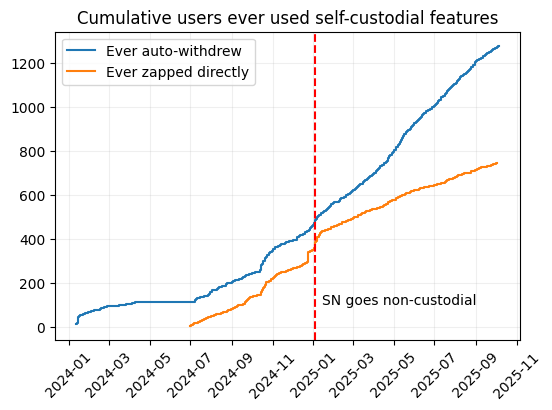

In [209]:
# plot cumulative wallet attaches

plot_df1 = autowithdraw_df['first_auto_withdraw'].dt.date.value_counts().sort_index().cumsum()
plot_df2 = sentsats_df['first_sent_sats'].dt.date.value_counts().sort_index().cumsum()

plt.figure(figsize=(6,4))
plt.step(plot_df1.index, plot_df1.values, where='post', label='Ever auto-withdrew')
plt.step(plot_df2.index, plot_df2.values, where='post', label='Ever zapped directly')
plt.axvline(globals.nc_date, color='red', linestyle='--')
plt.text(globals.nc_date + pd.to_timedelta(10,unit='D'), 100, 'SN goes non-custodial', ha='left')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.title("Cumulative users ever used self-custodial features")
plt.grid(alpha=0.2)
plt.show()

In [210]:
gtrends_df = pd.read_csv(os.path.join(RAW_DATA_PATH, "google-trends-bitcoin.csv"))
gtrends_df['week_start'] = pd.to_datetime(gtrends_df['week_start'], utc=True)

In [211]:
price_df = pd.read_csv(os.path.join(RAW_DATA_PATH, "coinmarketcap-daily-historical.csv"), delimiter=';')
price_df['date'] = pd.to_datetime(price_df['timeOpen'])
price_df['price_mid'] = (price_df['high'] + price_df['low']) / 2

In [212]:
gtrends_df['price_avg'] = 0.0
gtrends_df['items'] = 0.0
for idx, row in gtrends_df.iterrows():
    week_start = row['week_start']
    week_end = week_start + pd.to_timedelta(7,unit='D')

    mask = (price_df['date']>=week_start) & (price_df['date']<week_end)
    gtrends_df.at[idx, 'price_avg'] = price_df.loc[mask, 'price_mid'].mean()

    mask = (item_df['created_at']>=week_start) & (item_df['created_at']<week_end) & (item_df['invoiceActionState']!='FAILED')
    items = item_df.loc[mask].shape[0]

    if items>35000:
        break

    gtrends_df.at[idx, 'items'] = items

In [222]:
temp_df = item_df.loc[mask].reset_index(drop=True)

In [227]:
temp_df['userId'].value_counts()
temp_df.loc[temp_df['userId']==30375]

,id,created_at,updated_at,title,text,url,userId,parentId,path,pinId,...,invoiceId,invoicePaidAt,cost,oldBoost,mcredits,commentMcredits,nDirectComments,subWeightedDownVotes,subWeightedVotes,randPollOptions
187,1193647,2025-08-25 19:06:08.810000+00:00,2025-08-25 19:16:09.784,redacted bio,https://stacker.news/items/1093223\n\nhttps://...,None,30375,NaN,1193647,NaN,...,NaN,NaT,0,0,176000,0,1,0.045663,0.436107,False
950,1096840,2025-08-25 10:49:54.534000+00:00,2025-08-25 10:59:35.317,None,*deleted by author*,None,30375,10688.0,5834.10688.1096840,NaN,...,NaN,NaT,0,0,0,0,0,0.000000,0.000000,False
951,1096844,2025-08-25 10:49:55.631000+00:00,2025-08-25 10:59:37.316,None,*deleted by author*,None,30375,10692.0,10637.10661.10692.1096844,NaN,...,NaN,NaT,0,0,0,0,0,0.000000,0.000000,False
973,1097579,2025-08-25 10:53:24.414000+00:00,2025-08-25 11:05:44.647,None,*deleted by author*,None,30375,11425.0,11418.11425.1097579,NaN,...,NaN,NaT,0,0,0,0,0,0.000000,0.000000,False
974,1097587,2025-08-25 10:53:26.631000+00:00,2025-08-25 11:05:48.644,None,*deleted by author*,None,30375,11433.0,11407.11433.1097587,NaN,...,NaN,NaT,0,0,0,0,0,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37119,1127007,2025-08-25 13:33:22.534000+00:00,2025-08-25 15:17:29.057,None,*deleted by author*,None,30375,136193.0,136193.1127007,NaN,...,NaN,NaT,0,0,0,0,0,0.000000,0.000000,False
37121,1127016,2025-08-25 13:33:25.697000+00:00,2025-08-25 15:17:30.977,None,*deleted by author*,None,30375,136202.0,136195.136202.1127016,NaN,...,NaN,NaT,0,0,0,0,0,0.000000,0.000000,False
37122,1127017,2025-08-25 13:33:26.005000+00:00,2025-08-25 15:17:30.978,None,*deleted by author*,None,30375,136203.0,136203.1127017,NaN,...,NaN,NaT,0,0,0,0,0,0.000000,0.000000,False
37123,1127024,2025-08-25 13:33:29.035000+00:00,2025-08-25 15:17:32.995,None,*deleted by author*,None,30375,136210.0,136210.1127024,NaN,...,NaN,NaT,0,0,0,0,0,0.000000,0.000000,False


In [229]:
temp_df['bio']

0        False
1        False
2        False
3        False
4        False
         ...  
38718    False
38719    False
38720    False
38721    False
38722    False
Name: bio, Length: 38723, dtype: bool

KeyError: 'posts'

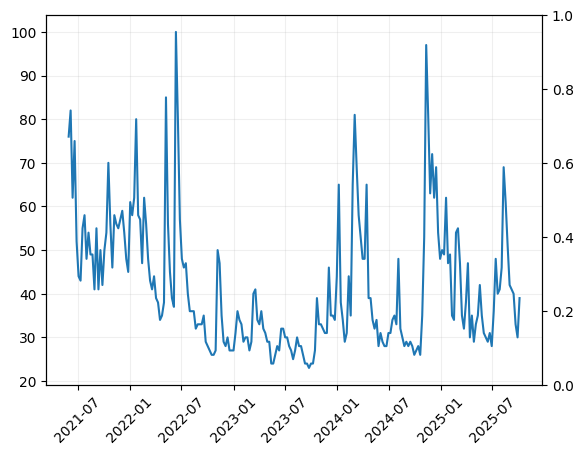

In [213]:
fig, ax1 = plt.subplots()
fig.figsize=(6,4)
ax1.plot(gtrends_df['week_start'], gtrends_df['bitcoin_gtrend'], color='tab:blue', label='google trends')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(alpha=0.2)
ax2 = ax1.twinx()
ax2.plot(gtrends_df['week_start'], gtrends_df['posts'], color='tab:orange', label='bitcoin price')
fig.legend(loc='lower center', bbox_to_anchor=(0.5, 1.0), bbox_transform=ax1.transAxes, ncol=2)
plt.show()

In [ ]:
gtrends_df.loc[gtrends_df['posts']>35000]

,week_start,bitcoin_gtrend,price_avg,posts
221,2025-08-24 00:00:00+00:00,51,111051.281973,38723.0


In [ ]:
start = pd.Timestamp('2024-08-24', tz='UTC')
end = start + pd.to_timedelta(7,unit='D')

temp_df = item_df.loc[(item_df['created_at']>=start) & (item_df['created_at']<end)]

temp_df


,id,created_at,updated_at,title,text,url,userId,parentId,path,pinId,...,invoiceId,invoicePaidAt,cost,oldBoost,mcredits,commentMcredits,nDirectComments,subWeightedDownVotes,subWeightedVotes,randPollOptions
2332,665985,2024-08-29 19:55:17.930000+00:00,2024-08-29 20:05:20.055,None,Linked in the post,None,8289,665984.0,665765.665790.665809.665984.665985,NaN,...,NaN,NaT,1,0,0,0,1,0.0,0.000000,False
6790,665112,2024-08-29 03:26:40.119000+00:00,2024-08-29 03:36:41.203,None,"Wow, there is also an event in India. The Indi...",None,22419,665104.0,665104.665112,NaN,...,NaN,NaT,1,0,0,0,1,0.0,0.000000,False
7125,666902,2024-08-30 15:38:13.815000+00:00,2024-08-30 15:40:57.348,None,@orthwyrm where's the **__@_'-'** ? did you ju...,None,13100,666531.0,666531.666902,NaN,...,NaN,NaT,1,0,0,0,1,0.0,0.000000,False
11061,665701,2024-08-29 16:08:03.454000+00:00,2024-08-29 16:18:04.734,None,Not yet!,None,16583,408405.0,238780.408405.665701,NaN,...,NaN,NaT,1,0,0,0,1,0.0,0.000000,False
11821,662227,2024-08-26 13:34:19.760000+00:00,2024-08-26 13:34:25.181,None,Same has happened to me since I linked. Though...,None,22727,661799.0,660950.661799.662227,NaN,...,NaN,NaT,1,0,0,0,1,0.0,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1222582,664323,2024-08-28 11:33:47.711000+00:00,2024-08-28 11:43:49.060,None,I don't need to scrounged around as I always p...,None,20799,664263.0,663870.663981.664125.664247.664258.664263.664323,NaN,...,NaN,NaT,1,0,0,0,1,0.0,0.000000,False
1222614,665091,2024-08-29 02:33:36.347000+00:00,2024-08-29 02:43:37.607,New epoch: reassess your security model,One of the many paradigm shifts that comes wit...,None,23137,NaN,665091,NaN,...,NaN,NaT,100,0,0,0,3,0.0,3.974491,False
1222904,665008,2024-08-29 00:57:34.650000+00:00,2024-08-29 01:07:35.853,None,I've read about it today. Don't mind me please...,None,24292,665001.0,664982.665001.665008,NaN,...,NaN,NaT,1,0,0,0,1,0.0,0.000000,False
1235314,664291,2024-08-28 11:02:07.472000+00:00,2024-08-28 11:12:09.710,None,Omg. Wtf?! MAJOR RED FLAG.,None,4538,664182.0,664033.664182.664291,NaN,...,NaN,NaT,1,0,0,0,1,0.0,0.000000,False
